Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
440/440 [==============================] - 134s 199ms/step - loss: 0.7381 - accuracy: 0.7936 - val_loss: 0.4631 - val_accuracy: 0.8159
Epoch 2/5
440/440 [==============================] - 79s 180ms/step - loss: 0.4440 - accuracy: 0.8258 - val_loss: 0.4270 - val_accuracy: 0.8315
Epoch 3/5
440/440 [==============================] - 78s 178ms/step - loss: 0.3880 - accuracy: 0.8464 - val_loss: 0.4102 - val_accuracy: 0.8386
Epoch 4/5
440/440 [==============================] - 78s 178ms/step - loss: 0.3438 - accuracy: 0.8641 - val_loss: 0.4228 - val_accuracy: 0.8401
Epoch 5/5
95/95 [==============================] - 9s 64ms/step


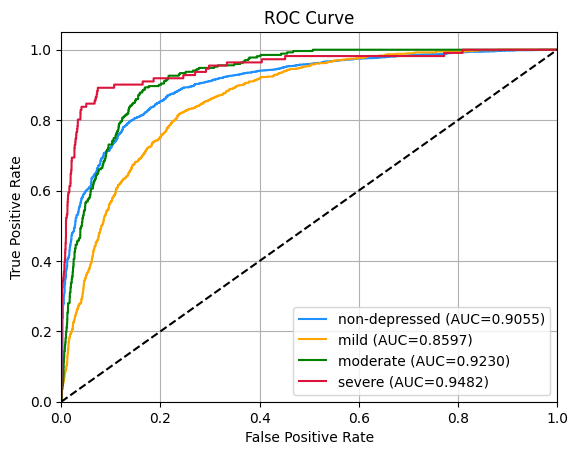

In [2]:
# Install required libraries
!pip install -q transformers datasets scikit-learn

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from transformers import ElectraTokenizer, TFElectraForSequenceClassification, ElectraConfig
from transformers import create_optimizer


# Load dataset
df = pd.read_csv('/content/SOD22_dataset.csv')
df = df[['tweet', 'label']].dropna()

# Label mapping
label_map = {'non-depressed': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
if df['label'].dtype == 'object':
    df['label'] = df['label'].map(label_map)

# Train-val-test split (stratified)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['tweet'], df['label'], test_size=0.3, stratify=df['label'], random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Tokenization
MODEL_NAME = 'google/electra-small-discriminator'
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)

max_length = 64
def tokenize(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=max_length)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# Convert to TensorFlow Datasets
def convert(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        tf.keras.utils.to_categorical(labels, num_classes=4)
    ))

batch_size = 64

train_dataset = convert(train_encodings, train_labels).shuffle(1000).batch(batch_size)
val_dataset = convert(val_encodings, val_labels).batch(batch_size)
test_dataset = convert(test_encodings, test_labels).batch(batch_size)

# Load ELECTRA model
config = ElectraConfig.from_pretrained(MODEL_NAME, num_labels=4)
model = TFElectraForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

# Optimizer and scheduler
epochs = 5
steps_per_epoch = len(train_dataset)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)

optimizer, lr_schedule = create_optimizer(
    init_lr=5e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps
)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

# Evaluate
pred_logits = model.predict(test_dataset).logits
y_true = tf.keras.utils.to_categorical(test_labels, num_classes=4)
y_pred = tf.nn.softmax(pred_logits).numpy()

# ROC-AUC Score per class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])

# Plot ROC Curve
plt.figure()
colors = ['dodgerblue', 'orange', 'green', 'crimson']
labels = ['non-depressed', 'mild', 'moderate', 'severe']

for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'{labels[i]} (AUC={roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
